In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import sys
import gc
from tqdm import tqdm
tqdm.pandas()
import time
from datetime import datetime
import datetime as dt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score,roc_auc_score,roc_curve
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import roc_curve
import os
import random
import seaborn as sns
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import LeakyReLU, BatchNormalization

2022-02-20 12:33:19.512517: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, LSTM, Dropout,GRU
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow as tf

In [3]:
def seed_everything(seed=51):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [4]:
seed_everything(seed=51)

In [5]:
data = pd.read_csv('15mindata.csv')

In [6]:
data.head()

,time,open
0,2012-01-01 00:00:00,4.58
1,2012-01-01 00:15:00,4.58
2,2012-01-01 00:30:00,4.58
3,2012-01-01 00:45:00,4.58
4,2012-01-01 01:00:00,4.58


In [7]:
data.shape

(350688, 2)

In [8]:
data.tail()

,time,open
350683,2021-12-31 22:45:00,46290.58
350684,2021-12-31 23:00:00,46303.98
350685,2021-12-31 23:15:00,46429.65
350686,2021-12-31 23:30:00,46350.44
350687,2021-12-31 23:45:00,46465.54


In [9]:
data['time'] = pd.to_datetime(data['time'])

In [10]:
data['time'].max()

Timestamp('2021-12-31 23:45:00')

In [11]:
data['time'].dt.year.value_counts()

2012    35136
2016    35136
2020    35136
2013    35040
2014    35040
2015    35040
2017    35040
2018    35040
2019    35040
2021    35040
Name: time, dtype: int64

In [12]:
data['year'] = data['time'].dt.year
data['month'] = data['time'].dt.month
data['day'] = data['time'].dt.day
data['hour'] = data['time'].dt.hour
data['minute'] = data['time'].dt.minute

In [13]:
data.head()

,time,open,year,month,day,hour,minute
0,2012-01-01 00:00:00,4.58,2012,1,1,0,0
1,2012-01-01 00:15:00,4.58,2012,1,1,0,15
2,2012-01-01 00:30:00,4.58,2012,1,1,0,30
3,2012-01-01 00:45:00,4.58,2012,1,1,0,45
4,2012-01-01 01:00:00,4.58,2012,1,1,1,0


In [14]:
#data['mod5'] = data['minute'] % 5
data = data[(data['year'] != 2012) & (data['hour'] % 4 ==0) & (data['minute'] == 0)].reset_index(drop=True)
#data = data[(data['year'] != 2012)].reset_index(drop=True)

#data = data[ (data['hour'] % 4 ==0) & (data['minute'] == 0)].reset_index(drop=True)

print(data.shape)

(19722, 7)


In [15]:
myarray = np.array(data['open'])

In [16]:
data.dtypes

time      datetime64[ns]
open             float64
year               int64
month              int64
day                int64
hour               int64
minute             int64
dtype: object

<AxesSubplot:>

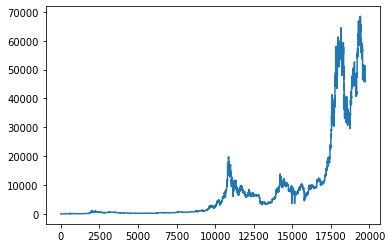

In [17]:
data['open'].plot()

In [18]:
input_data = []
target_data = []
time_step = 120
next_period = 1

In [19]:
for i in tqdm(range(len(myarray) - time_step-next_period)):
    input_data.append(myarray[i:i+time_step])
    target_data.append(myarray[i+time_step+next_period])

100%|████████████████████████████████| 19601/19601 [00:00<00:00, 1116684.59it/s]


In [20]:
input_data[0].shape

(120,)

In [21]:
input_data[1][-10:]

array([15.47, 15.32, 15.36, 15.38, 15.5 , 15.5 , 15.68, 15.65, 15.5 ,
       15.5 ])

In [22]:
target_data[1]

15.89

In [23]:
input_data = np.asarray(input_data)
target_data = np.asarray(target_data)
print(input_data.shape,target_data.shape)

(19601, 120) (19601,)


In [24]:
target_data[-1]

45728.28

In [25]:
input_data[-1][-50:]

array([48129.61, 48354.76, 48819.33, 51110.  , 50838.82, 51030.  ,
       50994.75, 50993.89, 50956.68, 51126.4 , 50819.99, 50844.13,
       50919.18, 50682.97, 50659.91, 50889.15, 50399.67, 49675.56,
       49930.39, 49748.89, 50049.34, 50342.51, 50775.48, 51009.02,
       50694.83, 50759.46, 51450.58, 51204.65, 50701.44, 49828.07,
       49227.14, 49200.39, 48937.47, 47689.46, 47543.74, 48001.01,
       47570.03, 47737.96, 47959.36, 47148.62, 46464.66, 46504.  ,
       46980.71, 47515.45, 47159.42, 47558.35, 47120.88, 47201.84,
       47191.08, 47975.76])

In [26]:
myarray[:1920]

array([ 13.24,  13.24,  13.24, ..., 440.21, 439.48, 433.58])

In [27]:
# real_target = (input_data[:,-1] - target_data) / input_data[:,-1] 
# real_target = real_target * 100

# real_target = real_target * -1

# print(real_target.shape)

In [28]:
# real_target[-1]

In [29]:
# sns.distplot(real_target)

In [30]:
# plt.hist(real_target,bins=500)
# plt.xlim((-15,15))
# plt.show()

In [31]:
# np.quantile(real_target,0.20)

In [32]:
mydata = pd.DataFrame(input_data,columns = ['T{}'.format(i) for i in range(1,time_step + 1,1)])

In [33]:
def label_maker(x):
    if x <= -1.25:
        return 0
    elif (-1.25 < x) & (x <= -0.3):
        return 1
    elif (-0.3 < x) & (x <= 0.3):
        return 2
    elif (0.3 < x) & (x <= 1.25):
        return 3
    elif 1.25 < x :
        return 4
    else:
        pass

In [34]:
def label_maker(x):
    if x <= -1.25:
        return 0
    elif (-1.25 < x) & (x <= 0):
        return 1
    elif (0 < x) & (x <= 1.25):
        return 2
    elif 1.25 < x :
        return 3
    else:
        pass

In [35]:
def label_maker(x):
    if x <= -1.5:
        return 0
    elif (-1.5 < x) & (x <= 1.5):
        return 1
    elif 1.5 < x :
        return 2
    else:
        pass

In [36]:
mydata.shape

(19601, 120)

In [37]:
mydata['target'] = target_data
mydata['last_timestep'] = input_data[:,-1] 
mydata['scaled_target'] = (target_data - input_data[:,-1]) / input_data[:,-1] 
mydata['percentile_target'] = mydata['scaled_target']*100
#mydata['categorical_target_change'] = mydata['percentile_target'].values
#mydata['categorical_target_change'] = mydata['percentile_target'].progress_apply(lambda x: label_maker(x) )
mydata['categorical_target_change'] = mydata['percentile_target'].progress_apply(lambda x: 1 if (x > 1.25) | (x < -1.25) else 0 )
#mydata['categorical_target_change'] = mydata['percentile_target'].progress_apply(lambda x: 1 if (x < -1.25) else 0 )

#mydata['categorical_target_change'] = mydata['percentile_target'].progress_apply(lambda x: 0 if x <= 0 else 1)

100%|█████████████████████████████████| 19601/19601 [00:00<00:00, 766207.69it/s]


In [38]:
#mydata['categorical_target'].value_counts()

In [39]:
mydata.tail()

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29,T30,T31,T32,T33,T34,T35,T36,T37,T38,T39,T40,T41,T42,T43,T44,T45,T46,T47,T48,T49,T50,T51,T52,T53,T54,T55,T56,T57,T58,T59,T60,T61,T62,T63,T64,T65,T66,T67,T68,T69,T70,T71,T72,T73,T74,T75,T76,T77,T78,T79,T80,T81,T82,T83,T84,T85,T86,T87,T88,T89,T90,T91,T92,T93,T94,T95,T96,T97,T98,T99,T100,T101,T102,T103,T104,T105,T106,T107,T108,T109,T110,T111,T112,T113,T114,T115,T116,T117,T118,T119,T120,target,last_timestep,scaled_target,percentile_target,categorical_target_change
19596,47140.54,48297.00,48021.75,48240.43,48745.11,48407.25,49389.99,49305.71,49301.20,49124.33,49623.26,50221.05,50053.90,48873.20,48740.01,48845.00,47252.02,46739.35,46702.76,46952.01,46999.99,47617.99,46853.87,46859.42,48336.95,48262.40,48209.51,48132.54,46632.30,48674.90,48864.98,48819.59,48712.23,49207.79,48578.61,47866.01,47632.38,47766.07,47007.25,47112.43,46528.83,46765.66,46133.83,46283.04,46364.09,47070.43,46858.56,46643.68,46834.47,47714.61,47515.09,47155.24,47239.81,46673.94,46681.24,46687.22,46429.19,46092.60,45974.09,46585.56,46914.17,47928.48,48579.77,48866.92,48418.48,48619.80,48887.59,49249.00,49206.43,48981.98,48879.28,48931.99,48588.17,48524.11,48129.61,48354.76,48819.33,51110.00,50838.82,51030.00,50994.75,50993.89,50956.68,51126.40,50819.99,50844.13,50919.18,50682.97,50659.91,50889.15,50399.67,49675.56,49930.39,49748.89,50049.34,50342.51,50775.48,51009.02,50694.83,50759.46,51450.58,51204.65,50701.44,49828.07,49227.14,49200.39,48937.47,47689.46,47543.74,48001.01,47570.03,47737.96,47959.36,47148.62,46464.66,46504.00,46980.71,47515.45,47159.42,47558.35,47201.84,47558.35,-0.007496,-0.749627,0
19597,48297.00,48021.75,48240.43,48745.11,48407.25,49389.99,49305.71,49301.20,49124.33,49623.26,50221.05,50053.90,48873.20,48740.01,48845.00,47252.02,46739.35,46702.76,46952.01,46999.99,47617.99,46853.87,46859.42,48336.95,48262.40,48209.51,48132.54,46632.30,48674.90,48864.98,48819.59,48712.23,49207.79,48578.61,47866.01,47632.38,47766.07,47007.25,47112.43,46528.83,46765.66,46133.83,46283.04,46364.09,47070.43,46858.56,46643.68,46834.47,47714.61,47515.09,47155.24,47239.81,46673.94,46681.24,46687.22,46429.19,46092.60,45974.09,46585.56,46914.17,47928.48,48579.77,48866.92,48418.48,48619.80,48887.59,49249.00,49206.43,48981.98,48879.28,48931.99,48588.17,48524.11,48129.61,48354.76,48819.33,51110.00,50838.82,51030.00,50994.75,50993.89,50956.68,51126.40,50819.99,50844.13,50919.18,50682.97,50659.91,50889.15,50399.67,49675.56,49930.39,49748.89,50049.34,50342.51,50775.48,51009.02,50694.83,50759.46,51450.58,51204.65,50701.44,49828.07,49227.14,49200.39,48937.47,47689.46,47543.74,48001.01,47570.03,47737.96,47959.36,47148.62,46464.66,46504.00,46980.71,47515.45,47159.42,47558.35,47120.88,47191.08,47120.88,0.001490,0.148979,0
19598,48021.75,48240.43,48745.11,48407.25,49389.99,49305.71,49301.20,49124.33,49623.26,50221.05,50053.90,48873.20,48740.01,48845.00,47252.02,46739.35,46702.76,46952.01,46999.99,47617.99,46853.87,46859.42,48336.95,48262.40,48209.51,48132.54,46632.30,48674.90,48864.98,48819.59,48712.23,49207.79,48578.61,47866.01,47632.38,47766.07,47007.25,47112.43,46528.83,46765.66,46133.83,46283.04,46364.09,47070.43,46858.56,46643.68,46834.47,47714.61,47515.09,47155.24,47239.81,46673.94,46681.24,46687.22,46429.19,46092.60,45974.09,46585.56,46914.17,47928.48,48579.77,48866.92,48418.48,48619.80,48887.59,49249.00,49206.43,48981.98,48879.28,48931.99,48588.17,48524.11,48129.61,48354.76,48819.33,51110.00,50838.82,51030.00,50994.75,50993.89,50956.68,51126.40,50819.99,50844.13,50919.18,50682.97,50659.91,50889.15,50399.67,49675.56,49930.39,49748.89,50049.34,50342.51,50775.48,51009.02,50694.83,50759.46,51450.58,51204.65,50701.44,49828.07,49227.14,49200.39,48937.47,47689.46,47543.74,48001.01,47570.03,47737.96,47959.36,47148.62,46464.66,46504.00,46980.71,47515.45,47159.42,47558.35,47120.88,47201.84,47975.76,47201.84,0.016396,1.639597,1
19599,48240.43,48745.11,48407.25,49389.99,49305.71,493

In [40]:
mydata.head()

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29,T30,T31,T32,T33,T34,T35,T36,T37,T38,T39,T40,T41,T42,T43,T44,T45,T46,T47,T48,T49,T50,T51,T52,T53,T54,T55,T56,T57,T58,T59,T60,T61,T62,T63,T64,T65,T66,T67,T68,T69,T70,T71,T72,T73,T74,T75,T76,T77,T78,T79,T80,T81,T82,T83,T84,T85,T86,T87,T88,T89,T90,T91,T92,T93,T94,T95,T96,T97,T98,T99,T100,T101,T102,T103,T104,T105,T106,T107,T108,T109,T110,T111,T112,T113,T114,T115,T116,T117,T118,T119,T120,target,last_timestep,scaled_target,percentile_target,categorical_target_change
0,13.24,13.24,13.24,13.24,13.20,13.14,13.22,13.22,13.12,13.15,13.14,13.13,13.09,13.18,13.10,13.15,13.02,13.00,13.12,13.19,13.20,13.24,13.16,13.22,13.19,13.15,13.11,13.12,13.10,13.03,13.15,13.06,13.06,13.10,13.14,13.10,13.15,13.14,13.04,13.15,13.15,13.20,13.20,13.20,13.26,13.30,13.43,13.48,13.50,13.40,13.34,13.60,13.32,13.36,13.58,13.55,13.56,13.70,13.70,14.19,14.00,13.87,13.90,13.98,14.02,14.00,14.00,13.92,14.00,14.06,14.04,14.03,13.89,14.00,14.03,13.93,13.95,13.94,13.64,13.51,13.60,13.90,13.98,14.06,14.10,14.02,13.90,14.05,14.14,14.23,14.20,14.27,14.35,14.43,14.48,14.48,14.53,14.70,14.49,14.85,14.81,15.40,15.36,15.50,15.44,15.29,15.50,15.51,15.57,15.47,15.47,15.47,15.32,15.36,15.38,15.50,15.50,15.68,15.65,15.50,15.71,15.50,0.013548,1.354839,1
1,13.24,13.24,13.24,13.20,13.14,13.22,13.22,13.12,13.15,13.14,13.13,13.09,13.18,13.10,13.15,13.02,13.00,13.12,13.19,13.20,13.24,13.16,13.22,13.19,13.15,13.11,13.12,13.10,13.03,13.15,13.06,13.06,13.10,13.14,13.10,13.15,13.14,13.04,13.15,13.15,13.20,13.20,13.20,13.26,13.30,13.43,13.48,13.50,13.40,13.34,13.60,13.32,13.36,13.58,13.55,13.56,13.70,13.70,14.19,14.00,13.87,13.90,13.98,14.02,14.00,14.00,13.92,14.00,14.06,14.04,14.03,13.89,14.00,14.03,13.93,13.95,13.94,13.64,13.51,13.60,13.90,13.98,14.06,14.10,14.02,13.90,14.05,14.14,14.23,14.20,14.27,14.35,14.43,14.48,14.48,14.53,14.70,14.49,14.85,14.81,15.40,15.36,15.50,15.44,15.29,15.50,15.51,15.57,15.47,15.47,15.47,15.32,15.36,15.38,15.50,15.50,15.68,15.65,15.50,15.50,15.89,15.50,0.025161,2.516129,1
2,13.24,13.24,13.20,13.14,13.22,13.22,13.12,13.15,13.14,13.13,13.09,13.18,13.10,13.15,13.02,13.00,13.12,13.19,13.20,13.24,13.16,13.22,13.19,13.15,13.11,13.12,13.10,13.03,13.15,13.06,13.06,13.10,13.14,13.10,13.15,13.14,13.04,13.15,13.15,13.20,13.20,13.20,13.26,13.30,13.43,13.48,13.50,13.40,13.34,13.60,13.32,13.36,13.58,13.55,13.56,13.70,13.70,14.19,14.00,13.87,13.90,13.98,14.02,14.00,14.00,13.92,14.00,14.06,14.04,14.03,13.89,14.00,14.03,13.93,13.95,13.94,13.64,13.51,13.60,13.90,13.98,14.06,14.10,14.02,13.90,14.05,14.14,14.23,14.20,14.27,14.35,14.43,14.48,14.48,14.53,14.70,14.49,14.85,14.81,15.40,15.36,15.50,15.44,15.29,15.50,15.51,15.57,15.47,15.47,15.47,15.32,15.36,15.38,15.50,15.50,15.68,15.65,15.50,15.50,15.71,16.10,15.71,0.024825,2.482495,1
3,13.24,13.20,13.14,13.22,13.22,13.12,13.15,13.14,13.13,13.09,13.18,13.10,13.15,13.02,13.00,13.12,13.19,13.20,13.24,13.16,13.22,13.19,13.15,13.11,13.12,13.10,13.03,13.15,13.06,13.06,13.10,13.14,13.10,13.15,13.14,13.04,13.15,13.15,13.20,13.20,13.20,13.26,13.30,13.43,13.48,13.50,13.40,13.34,13.60,13.32,13.36,13.58,13.55,13.56,13.70,13.70,14.19,14.00,13.87,13.90,13.98,14.02,14.00,14.00,13.92,14.00,14.06,14.04,14.03,13.89,14.00,14.03,13.93,13.95,13.94,13.64,13.51,13.60,13.90,13.98,14.06,14.10,14.02,13.90,14.05,14.14,14.23,14.20,14.27,14.35,14.43,14.48,14.48,14.53,14.70,14.49,14.85,14.81,15.40,15.36,15.50,15.44,15.29,15.50,15.51,15.57,15.47,15.47,15.47,15.32,15.36,15.38,15.50,15.50,15.68,15.65,15.50,15.50,15.71,15.89,16.93,15.89,0.065450,6.544997,1
4,13.20,13.14,13.22,13.22,13.12,13.15,13.14,13.13,13.09,13.18,13.10,13.15,13.02,13.00,13.12,13.19,13.20,13.24,13.16,13.22,13.19,13.15,13.11,13.12,13.10,13.03,13.15,13.06,13.06,13.10,13.14,13.10,13.15,13.14,13.04,13.15,13.15,13.20,13.20,13.20,13.26,13.30,13.43,13.48,13.50,13.40,13.34,13.60,13.32,13.36,13.58,13.55,13.56,13.70,13.70,14.19,14.00,13.87,13.90,13.98,14.02,14.00,14.00,13.92,14.00,14.06,14.04,14.03,13

In [41]:
mydata['columnwise_min'] = mydata.iloc[:,:time_step].min(axis=1)
mydata['columnwise_max'] = mydata.iloc[:,:time_step].max(axis=1)
mydata['columnwise_median'] = mydata.iloc[:,:time_step].median(axis=1)

In [42]:
mydata.head()

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29,T30,T31,T32,T33,T34,T35,T36,T37,T38,T39,T40,T41,T42,T43,T44,T45,T46,T47,T48,T49,T50,T51,T52,T53,T54,T55,T56,T57,T58,T59,T60,T61,T62,T63,T64,T65,T66,T67,T68,T69,T70,T71,T72,T73,T74,T75,T76,T77,T78,T79,T80,T81,T82,T83,T84,T85,T86,T87,T88,T89,T90,T91,T92,T93,T94,T95,T96,T97,T98,T99,T100,T101,T102,T103,T104,T105,T106,T107,T108,T109,T110,T111,T112,T113,T114,T115,T116,T117,T118,T119,T120,target,last_timestep,scaled_target,percentile_target,categorical_target_change,columnwise_min,columnwise_max,columnwise_median
0,13.24,13.24,13.24,13.24,13.20,13.14,13.22,13.22,13.12,13.15,13.14,13.13,13.09,13.18,13.10,13.15,13.02,13.00,13.12,13.19,13.20,13.24,13.16,13.22,13.19,13.15,13.11,13.12,13.10,13.03,13.15,13.06,13.06,13.10,13.14,13.10,13.15,13.14,13.04,13.15,13.15,13.20,13.20,13.20,13.26,13.30,13.43,13.48,13.50,13.40,13.34,13.60,13.32,13.36,13.58,13.55,13.56,13.70,13.70,14.19,14.00,13.87,13.90,13.98,14.02,14.00,14.00,13.92,14.00,14.06,14.04,14.03,13.89,14.00,14.03,13.93,13.95,13.94,13.64,13.51,13.60,13.90,13.98,14.06,14.10,14.02,13.90,14.05,14.14,14.23,14.20,14.27,14.35,14.43,14.48,14.48,14.53,14.70,14.49,14.85,14.81,15.40,15.36,15.50,15.44,15.29,15.50,15.51,15.57,15.47,15.47,15.47,15.32,15.36,15.38,15.50,15.50,15.68,15.65,15.50,15.71,15.50,0.013548,1.354839,1,13.0,15.68,13.670
1,13.24,13.24,13.24,13.20,13.14,13.22,13.22,13.12,13.15,13.14,13.13,13.09,13.18,13.10,13.15,13.02,13.00,13.12,13.19,13.20,13.24,13.16,13.22,13.19,13.15,13.11,13.12,13.10,13.03,13.15,13.06,13.06,13.10,13.14,13.10,13.15,13.14,13.04,13.15,13.15,13.20,13.20,13.20,13.26,13.30,13.43,13.48,13.50,13.40,13.34,13.60,13.32,13.36,13.58,13.55,13.56,13.70,13.70,14.19,14.00,13.87,13.90,13.98,14.02,14.00,14.00,13.92,14.00,14.06,14.04,14.03,13.89,14.00,14.03,13.93,13.95,13.94,13.64,13.51,13.60,13.90,13.98,14.06,14.10,14.02,13.90,14.05,14.14,14.23,14.20,14.27,14.35,14.43,14.48,14.48,14.53,14.70,14.49,14.85,14.81,15.40,15.36,15.50,15.44,15.29,15.50,15.51,15.57,15.47,15.47,15.47,15.32,15.36,15.38,15.50,15.50,15.68,15.65,15.50,15.50,15.89,15.50,0.025161,2.516129,1,13.0,15.68,13.700
2,13.24,13.24,13.20,13.14,13.22,13.22,13.12,13.15,13.14,13.13,13.09,13.18,13.10,13.15,13.02,13.00,13.12,13.19,13.20,13.24,13.16,13.22,13.19,13.15,13.11,13.12,13.10,13.03,13.15,13.06,13.06,13.10,13.14,13.10,13.15,13.14,13.04,13.15,13.15,13.20,13.20,13.20,13.26,13.30,13.43,13.48,13.50,13.40,13.34,13.60,13.32,13.36,13.58,13.55,13.56,13.70,13.70,14.19,14.00,13.87,13.90,13.98,14.02,14.00,14.00,13.92,14.00,14.06,14.04,14.03,13.89,14.00,14.03,13.93,13.95,13.94,13.64,13.51,13.60,13.90,13.98,14.06,14.10,14.02,13.90,14.05,14.14,14.23,14.20,14.27,14.35,14.43,14.48,14.48,14.53,14.70,14.49,14.85,14.81,15.40,15.36,15.50,15.44,15.29,15.50,15.51,15.57,15.47,15.47,15.47,15.32,15.36,15.38,15.50,15.50,15.68,15.65,15.50,15.50,15.71,16.10,15.71,0.024825,2.482495,1,13.0,15.71,13.785
3,13.24,13.20,13.14,13.22,13.22,13.12,13.15,13.14,13.13,13.09,13.18,13.10,13.15,13.02,13.00,13.12,13.19,13.20,13.24,13.16,13.22,13.19,13.15,13.11,13.12,13.10,13.03,13.15,13.06,13.06,13.10,13.14,13.10,13.15,13.14,13.04,13.15,13.15,13.20,13.20,13.20,13.26,13.30,13.43,13.48,13.50,13.40,13.34,13.60,13.32,13.36,13.58,13.55,13.56,13.70,13.70,14.19,14.00,13.87,13.90,13.98,14.02,14.00,14.00,13.92,14.00,14.06,14.04,14.03,13.89,14.00,14.03,13.93,13.95,13.94,13.64,13.51,13.60,13.90,13.98,14.06,14.10,14.02,13.90,14.05,14.14,14.23,14.20,14.27,14.35,14.43,14.48,14.48,14.53,14.70,14.49,14.85,14.81,15.40,15.36,15.50,15.44,15.29,15.50,15.51,15.57,15.47,15.47,15.47,15.32,15.36,15.38,15.50,15.50,15.68,15.65,15.50,15.50,15.71,15.89,16.93,15.89,0.065450,6.544997,1,13.0,15.89,13.880
4,13.20,13.14,13.22,13.22,13.12,13.15,13.14,13.13,13.09,13.18,13.10,13.15,13.02,13.00,13.12,13.19,13.20,13.24,13.16,13.22,13.19,13.15,13.11,13.12,13.10,13.03,13.15,13.06,13.06,13.10,13.14,13.10,13.15,13.14,13.04,13.15,13.15,13.20,13.20,13.20,13.26,13.30,13.43,13.48,13.50,13.40,13.34,13.60,13

In [43]:
mydata.shape

(19601, 128)

In [44]:
#mydata = mydata[mydata['categorical_target_change'].isin([0,2])]

In [45]:
#mydata[[f'T{x}' for x in range (1,time_step+1,1) ]] = np.array([ np.interp( x, ( np.array(x).min(),np.array(x).max() ), (-1,1) ) for x in mydata[[f'T{x}' for x in range (1,time_step+1,1) ]].values.tolist() ])

In [46]:
for i in range(1,time_step+1,1):
    mydata['T{}'.format(i)] = (mydata['T{}'.format(i)] - mydata['columnwise_min']) / (mydata['columnwise_max'] - mydata['columnwise_min'])

In [47]:
mydata.head()

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29,T30,T31,T32,T33,T34,T35,T36,T37,T38,T39,T40,T41,T42,T43,T44,T45,T46,T47,T48,T49,T50,T51,T52,T53,T54,T55,T56,T57,T58,T59,T60,T61,T62,T63,T64,T65,T66,T67,T68,T69,T70,T71,T72,T73,T74,T75,T76,T77,T78,T79,T80,T81,T82,T83,T84,T85,T86,T87,T88,T89,T90,T91,T92,T93,T94,T95,T96,T97,T98,T99,T100,T101,T102,T103,T104,T105,T106,T107,T108,T109,T110,T111,T112,T113,T114,T115,T116,T117,T118,T119,T120,target,last_timestep,scaled_target,percentile_target,categorical_target_change,columnwise_min,columnwise_max,columnwise_median
0,0.089552,0.089552,0.089552,0.089552,0.074627,0.052239,0.082090,0.082090,0.044776,0.055970,0.052239,0.048507,0.033582,0.067164,0.037313,0.055970,0.007463,0.000000,0.044776,0.070896,0.074627,0.089552,0.059701,0.082090,0.070896,0.055970,0.041045,0.044776,0.037313,0.011194,0.055970,0.022388,0.022388,0.037313,0.052239,0.037313,0.055970,0.052239,0.014925,0.055970,0.055970,0.074627,0.074627,0.074627,0.097015,0.111940,0.160448,0.179104,0.186567,0.149254,0.126866,0.223881,0.119403,0.134328,0.216418,0.205224,0.208955,0.261194,0.261194,0.444030,0.373134,0.324627,0.335821,0.365672,0.380597,0.373134,0.373134,0.343284,0.373134,0.395522,0.388060,0.384328,0.332090,0.373134,0.384328,0.347015,0.354478,0.350746,0.238806,0.190299,0.223881,0.335821,0.365672,0.395522,0.410448,0.380597,0.335821,0.391791,0.425373,0.458955,0.447761,0.473881,0.503731,0.533582,0.552239,0.552239,0.570896,0.634328,0.555970,0.690299,0.675373,0.895522,0.880597,0.932836,0.910448,0.854478,0.932836,0.936567,0.958955,0.921642,0.921642,0.921642,0.865672,0.880597,0.888060,0.932836,0.932836,1.000000,0.988806,0.932836,15.71,15.50,0.013548,1.354839,1,13.0,15.68,13.670
1,0.089552,0.089552,0.089552,0.074627,0.052239,0.082090,0.082090,0.044776,0.055970,0.052239,0.048507,0.033582,0.067164,0.037313,0.055970,0.007463,0.000000,0.044776,0.070896,0.074627,0.089552,0.059701,0.082090,0.070896,0.055970,0.041045,0.044776,0.037313,0.011194,0.055970,0.022388,0.022388,0.037313,0.052239,0.037313,0.055970,0.052239,0.014925,0.055970,0.055970,0.074627,0.074627,0.074627,0.097015,0.111940,0.160448,0.179104,0.186567,0.149254,0.126866,0.223881,0.119403,0.134328,0.216418,0.205224,0.208955,0.261194,0.261194,0.444030,0.373134,0.324627,0.335821,0.365672,0.380597,0.373134,0.373134,0.343284,0.373134,0.395522,0.388060,0.384328,0.332090,0.373134,0.384328,0.347015,0.354478,0.350746,0.238806,0.190299,0.223881,0.335821,0.365672,0.395522,0.410448,0.380597,0.335821,0.391791,0.425373,0.458955,0.447761,0.473881,0.503731,0.533582,0.552239,0.552239,0.570896,0.634328,0.555970,0.690299,0.675373,0.895522,0.880597,0.932836,0.910448,0.854478,0.932836,0.936567,0.958955,0.921642,0.921642,0.921642,0.865672,0.880597,0.888060,0.932836,0.932836,1.000000,0.988806,0.932836,0.932836,15.89,15.50,0.025161,2.516129,1,13.0,15.68,13.700
2,0.088561,0.088561,0.073801,0.051661,0.081181,0.081181,0.044280,0.055351,0.051661,0.047970,0.033210,0.066421,0.036900,0.055351,0.007380,0.000000,0.044280,0.070111,0.073801,0.088561,0.059041,0.081181,0.070111,0.055351,0.040590,0.044280,0.036900,0.011070,0.055351,0.022140,0.022140,0.036900,0.051661,0.036900,0.055351,0.051661,0.014760,0.055351,0.055351,0.073801,0.073801,0.073801,0.095941,0.110701,0.158672,0.177122,0.184502,0.147601,0.125461,0.221402,0.118081,0.132841,0.214022,0.202952,0.206642,0.258303,0.258303,0.439114,0.369004,0.321033,0.332103,0.361624,0.376384,0.369004,0.369004,0.339483,0.369004,0.391144,0.383764,0.380074,0.328413,0.369004,0.380074,0.343173,0.350554,0.346863,0.236162,0.188192,0.221402,0.332103,0.361624,0.391144,0.405904,0.376384,0.332103,0.387454,0.420664,0.453875,0.442804,0.468635,0.498155,0.527675,0.546125,0.546125,0.564576,0.627306,0.549815,0.682657,0.667897,0.885609,0.870849,0.922509,0.900369,0.845018,0.922509,0.926199,0.948339,0.911439,0.911439,0.911439,0.856089,0.870849,0.878229,0.922509,0.922509,0.988930,0.977860,0.922509,0.922509,1.000000,16.10,15.71,0.024825,2.482495,1,13

In [48]:
mydata['percentile_target'].describe()

count    19601.000000
mean         0.126995
std          3.047679
min        -61.462500
25%         -0.722221
50%          0.078567
75%          0.975071
max        151.258428
Name: percentile_target, dtype: float64

In [49]:
#mydata['categorical_target'].value_counts(normalize=True)

In [50]:
mydata['categorical_target_change'].value_counts(normalize=True)

0    0.621601
1    0.378399
Name: categorical_target_change, dtype: float64

In [51]:
X_train = mydata[['T{}'.format(t) for t in range(1,time_step +1,1) ]][:int(len(mydata)*0.70)].values
X_val = mydata[['T{}'.format(t) for t in range(1,time_step + 1,1) ]][int(len(mydata)*0.70):int(len(mydata)*0.85)].values
X_test = mydata[['T{}'.format(t) for t in range(1,time_step + 1,1) ]][int(len(mydata)*0.85):].values
# y_train = pd.get_dummies(mydata['categorical_target'][:int(len(mydata)*0.7)]).values
# y_val = pd.get_dummies(mydata['categorical_target'][int(len(mydata)*0.7):int(len(mydata)*0.85)]).values
# y_test = pd.get_dummies(mydata['categorical_target'][int(len(mydata)*0.85):]).values
y_train = mydata['categorical_target_change'][:int(len(mydata)*0.70)]
y_val = mydata['categorical_target_change'][int(len(mydata)*0.70):int(len(mydata)*0.85)]
y_test = mydata['categorical_target_change'][int(len(mydata)*0.85):]

print(X_train.shape,X_val.shape,X_test.shape,y_train.shape,y_val.shape,y_test.shape)

(13720, 120) (2940, 120) (2941, 120) (13720,) (2940,) (2941,)


In [52]:
y_train.value_counts(normalize=True)

0    0.631195
1    0.368805
Name: categorical_target_change, dtype: float64

In [53]:
weight_dict= {x[0]: 1/x[1]  for x in y_train.value_counts(normalize=True).to_dict().items()}

In [54]:
weight_dict

{0: 1.584295612009238, 1: 2.7114624505928853}

In [55]:
y_val.value_counts(normalize=True)

0    0.647619
1    0.352381
Name: categorical_target_change, dtype: float64

In [56]:
y_test.value_counts(normalize=True)

0    0.550833
1    0.449167
Name: categorical_target_change, dtype: float64

In [57]:
X_train.shape

(13720, 120)

In [58]:
#X_train,y_train = shuffle(X_train,y_train,random_state=60)

In [59]:
#from imblearn.over_sampling import SMOTE

In [60]:
# if False:
    
#     smote = SMOTE(random_state=51,sampling_strategy={0:10000,1:10000,2:10000})
#     X_train, y_train = smote.fit_resample(X_train, y_train)
#     print(X_train.shape,y_train.shape)
#     #X_train,y_train = shuffle(X_train,y_train)

In [61]:
# y_train = pd.get_dummies(y_train)
# y_val = pd.get_dummies(y_val)
# y_test = pd.get_dummies(y_test)

In [62]:
#X_train = np.load('X_train.npy')
#y_train = np.load('y_train.npy')

In [63]:
X_train.shape

(13720, 120)

In [64]:
#n_features = 16
#X_train = X_train.reshape((X_train.shape[0], time_step, n_features))
#X_val = X_val.reshape((X_val.shape[0], time_step, n_features))
#X_test = X_test.reshape((X_test.shape[0], time_step, n_features))

n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_train.shape[1], n_features))

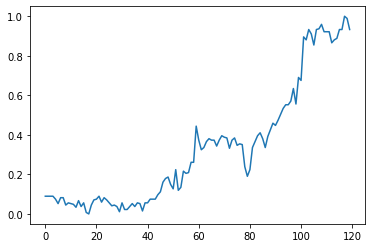

In [65]:
plt.plot(X_train[0])
plt.show()

In [66]:
X_train, y_train = shuffle(X_train,y_train,random_state=60)

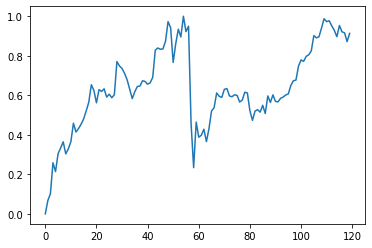

In [67]:
plt.plot(X_train[0])
plt.show()

In [68]:
X_train.shape

(13720, 120, 1)

In [69]:
#X_train = np.random.rand(X_train.shape[0],X_train.shape[1],X_train.shape[2])

In [70]:
X_train.shape

(13720, 120, 1)

In [71]:
tf.keras.backend.clear_session()

In [72]:
X_train.shape

(13720, 120, 1)

In [73]:
reduce_lr = ReduceLROnPlateau( monitor='val_loss', factor=0.05, patience=5 )

In [74]:
model = Sequential()
model.add(GRU(256, activation='tanh', input_shape=(time_step, n_features)))
model.add(Dropout(0.2))
model.add(Dense(128))
model.add(LeakyReLU(alpha=0.2))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=Adam(learning_rate=3e-4), metrics=[tf.keras.metrics.AUC(),'accuracy'])

2022-02-20 12:33:22.705336: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-20 12:33:22.706089: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-20 12:33:22.734462: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-20 12:33:22.734634: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1050 computeCapability: 6.1
coreClock: 1.493GHz coreCount: 5 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 104.43GiB/s
2022-02-20 12:33:22.734657: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-02-20 12:33:22.736567: I tensorflow/stream_executor/platform/def

In [75]:
# model = Sequential()
# model.add(Dense(1024,activation='relu',input_shape = (X_train.shape[1],)))
# model.add(Dense(1024,activation='relu'))
# model.add(Dense(1024,activation='relu'))
# model.add(Dense(3,activation='softmax'))
# model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0003), metrics=['accuracy',tf.keras.metrics.AUC()])

In [76]:
X_train.shape

(13720, 120, 1)

In [77]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 256)               198912    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 231,937
Trainable params: 231,937
Non-trainable params: 0
__________________________________________________

In [78]:
#from tensorflow.keras.models import load_model
#model = load_model("LSTM_model_2020_09_17.h5",compile = False)

In [79]:
model.fit(X_train, y_train, epochs =50 , validation_data = (X_val,y_val) ,batch_size = 8, callbacks=[reduce_lr])

2022-02-20 12:33:24.236275: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-20 12:33:24.254688: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2799925000 Hz


Epoch 1/50


2022-02-20 12:33:25.274316: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-02-20 12:33:25.450091: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-02-20 12:33:25.469736: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


1715/1715 [==============================] - 23s 12ms/step - loss: 0.6609 - auc: 0.5268 - accuracy: 0.6278 - val_loss: 0.6488 - val_auc: 0.5095 - val_accuracy: 0.6476
Epoch 2/50
1715/1715 [==============================] - 20s 12ms/step - loss: 0.6594 - auc: 0.5269 - accuracy: 0.6280 - val_loss: 0.6477 - val_auc: 0.5380 - val_accuracy: 0.6476
Epoch 3/50
1715/1715 [==============================] - 20s 12ms/step - loss: 0.6551 - auc: 0.5395 - accuracy: 0.6326 - val_loss: 0.6476 - val_auc: 0.5435 - val_accuracy: 0.6469
Epoch 4/50
1715/1715 [==============================] - 20s 12ms/step - loss: 0.6547 - auc: 0.5446 - accuracy: 0.6309 - val_loss: 0.6487 - val_auc: 0.5479 - val_accuracy: 0.6473
Epoch 5/50
1715/1715 [==============================] - 20s 11ms/step - loss: 0.6531 - auc: 0.5542 - accuracy: 0.6349 - val_loss: 0.6438 - val_auc: 0.5584 - val_accuracy: 0.6483
Epoch 6/50
1715/1715 [==============================] - 20s 12ms/step - loss: 0.6515 - auc: 0.5608 - accuracy: 0.6338 - v

# Train

In [80]:
y_train_predicted = model.predict_proba(X_train)

/home/muhammed/Documents/Trading-Bot/TRADING_ENV/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


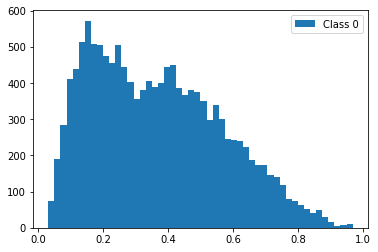

In [81]:
plt.hist(y_train_predicted[:,0],bins=50, label = "Class 0")
plt.legend()
plt.show()

In [82]:
roc_auc_score(y_train,y_train_predicted)

0.7517254379318845

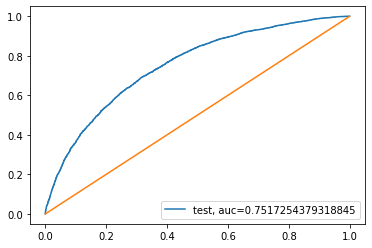

In [83]:
fpr, tpr, _ = roc_curve(y_train,  y_train_predicted)
auc = roc_auc_score(y_train, y_train_predicted)
plt.plot(fpr,tpr,label="test, auc="+str(auc))
plt.plot([0,1],[0,1])
plt.legend(loc=4)
plt.show()

# Val

In [84]:
y_val_predicted = model.predict_proba(X_val)

/home/muhammed/Documents/Trading-Bot/TRADING_ENV/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


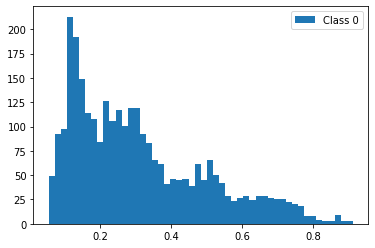

In [85]:
plt.hist(y_val_predicted[:,0],bins=50, label = "Class 0")
plt.legend()
plt.show()

In [86]:
roc_auc_score(y_val,y_val_predicted)

0.6317020051263749

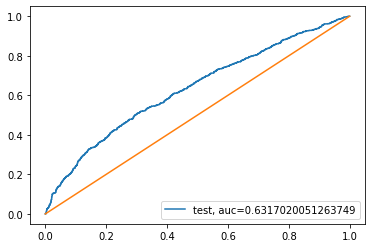

In [87]:
fpr, tpr, _ = roc_curve(y_val,  y_val_predicted)
auc = roc_auc_score(y_val, y_val_predicted)
plt.plot(fpr,tpr,label="test, auc="+str(auc))
plt.plot([0,1],[0,1])
plt.legend(loc=4)
plt.show()

# Test

In [88]:
y_test_predicted = model.predict_proba(X_test)

/home/muhammed/Documents/Trading-Bot/TRADING_ENV/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


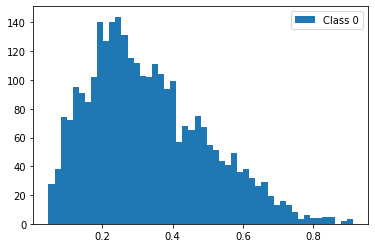

In [89]:
plt.hist(y_test_predicted[:,0],bins=50, label = "Class 0")
plt.legend()
plt.show()

In [90]:
roc_auc_score(y_test,y_test_predicted)

0.5515023224082017

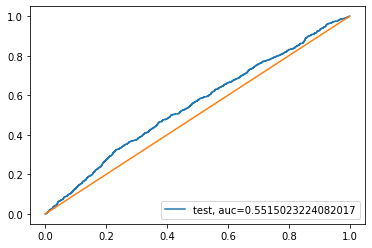

In [91]:
fpr, tpr, _ = roc_curve(y_test,  y_test_predicted)
auc = roc_auc_score(y_test, y_test_predicted)
plt.plot(fpr,tpr,label="test, auc="+str(auc))
plt.plot([0,1],[0,1])
plt.legend(loc=4)
plt.show()

In [92]:
mydata.shape[0] == X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

True